## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [2]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

# Generate a true trajectory 

In [5]:
N = 26
t = 2
vx_0 = -50
vy_0 = -45
x_0 = 13500 / 2 ** 0.5
y_0 = 13500 / 2 ** 0.5
vx = np.ones((N)) * vx_0
vy = np.ones((N)) * vy_0
x = np.ones((N)) * x_0 + (vx * t).dot(np.triu(np.ones((N, N)), 1))
y = np.ones((N)) * x_0 + (vy * t).dot(np.triu(np.ones((N, N)), 1))

# Generate also true values of range $D$ and azimut $\beta$

In [6]:
D = (x**2 + y**2) ** 0.5
b = np.arctan(x / y)

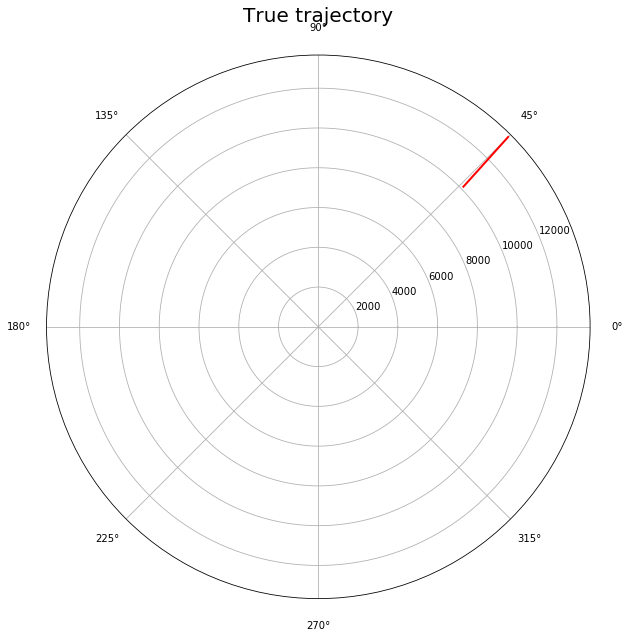

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('True trajectory', fontsize = 20)
ax.plot(b, D, 'r', linewidth=2)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Generate measurements $D^m$ and $\beta^m$

In [26]:
sigma_D = 20
sigma_b = 0.02
D_n = np.random.normal(0, sigma_D, N)
b_n = np.random.normal(0, sigma_b, N)
D_m = D + D_n
b_m = b + b_n

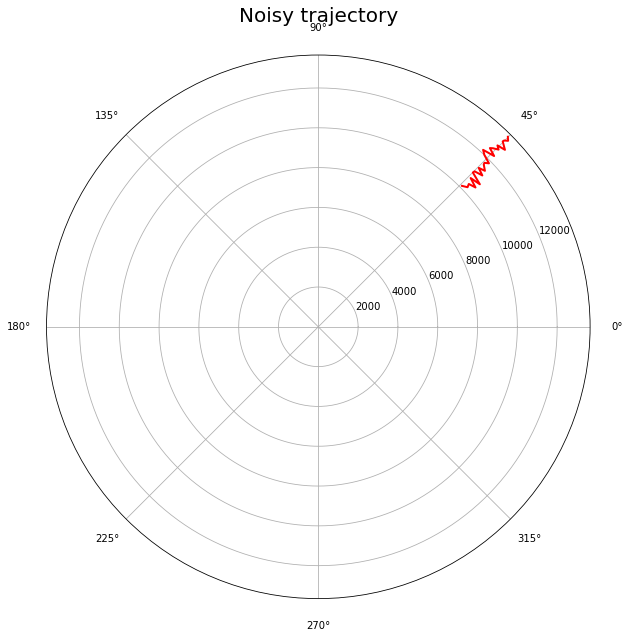

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('Noisy trajectory', fontsize = 20)
ax.plot(b_m, D_m, 'r', linewidth=2)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Transform polar coordinates 

In [ ]:
x_m = D_m * np.cos(b_m)
y_m = D_m * np.cos(b_m)
